---
title: 9.2 注意力汇聚：Nadaraya-Watson 核回归
date: 2024-5-29 11:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 2 注意力汇聚：Nadaraya-Watson核回归

- 查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚；注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。以Nadaraya‐Watson核回归模型为例介绍注意力汇聚

In [71]:
import torch
from torch import nn
from d2l import torch as d2l

## 2.1 生成数据集

- 简单起见，考虑下面这个回归问题：给定的成对的“输入－输出”数据集$\{(x_1, y_1), \ldots, (x_n, y_n)\}$，如何学习$f$来预测任意新输入$x$所对应的输出$\hat{y} = f(x)$？

- 生成一个人工数据集：

$$y_i = 2 \sin(x_ i) + x_ i ^{0.8} + \epsilon, \epsilon \sim \mathcal{N}(0, 0.5)$$

- 生成50个训练样本和50个测试样本。为了更好地可视化之后的注意力模式，需要将训练样本进行排序。

In [72]:
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本，从0到5之间的随机数

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数

- 定义函数，绘制所有的训练样本（样本由圆圈表示），不带噪声项的真实数据生成函数f（标记为“Truth”），以及学习得到的预测函数（标记为“Pred”）。

In [73]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat],'x','y',legend=['Truth','Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train,y_train,'o',alpha=0.5)

## 2.2 平均汇聚

- 使用平均汇聚，真实函数与预测函数相差很大

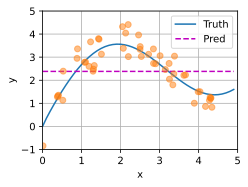

In [74]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

y_hat = torch.repeat_interleave(y_train.mean(), n_test) # 将y的均值重复n_test次
plot_kernel_reg(y_hat)

## 2.3 非参数注意力汇聚

- 平均汇聚忽略了输入$x_ i$。于是Nadaraya和Watson提出了一个更好的想法，根据输入的位置对输出$y_ i$进行加权：

$$ f(x) = \sum_{i=1}^n \frac{K(x - x_ i)}{\sum_{j = 1}^n K(x - x_ j)} y_ i$$

- 其中K是核（kernel）。上述预测器被称为Nadaraya-Watson核回归。受此启发，我们可以从注意力机制框架的角度重写，成为一个更加通用的注意力汇聚（attention pooling）公式：

$$ f(x) = \sum_{i=1}^n \alpha(x, x_ i) y_ i$$

- 其中x是查询，$x_ i, y_ i$是键值对。注意力汇聚是$y_ i$的加权平均。将查询x和键$x_ i$之间的关系建模为注意力权重$\alpha(x, x_ i)$，这个权重将被分配给每一个对应值$y_ i$。对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：它们是非负的，并且总和为1。

- 为了更好地理解注意力汇聚，下面考虑一个高斯核:

$$ K(u) = \frac { 1 } { \sqrt { 2 \pi } } \exp ( - \frac { u ^ 2 } { 2 } )$$

- 因此

$$ \begin{aligned} f(x) & = \sum _ { i = 1 } ^ { n } \alpha ( x , x _ { i } ) y _ { i } \\ & = \sum _ { i = 1 } ^ { n } \frac { \exp \left( - \frac { 1 } { 2 } ( x - x _ { i } ) ^ { 2 } \right) } { \sum _ { j = 1 } ^ { n } \exp \left( - \frac { 1 } { 2 } ( x - x _ { j } ) ^ { 2 } \right) } y _ { i } \\ & = \sum _ { i = 1 } ^ { n } softmax ( - \frac { 1 } { 2 } ( x - x _ { i } ) ^ { 2 } ) y _ { i } \end{aligned} $$

- 如果一个键$x_ i$与查询x越相似，那么分配给这个键对应值$y_ i$的注意力权重就越大，也就“获得了更多的注意力”

- Nadaraya‐Watson核回归是一个非参数模型。

- 基于这个非参数的注意力汇聚模型来绘制预测结果。从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

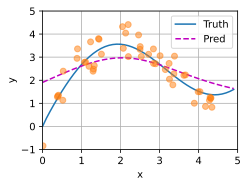

In [75]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# print(x_test)   # 列向量：50个
# print(X_repeat) # 50行，一行是重复的n_train个值
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1) #按dim=1方向进行softmax，即每一行的元素相加和为1
# print(X_repeat)
# print(x_train) # x_train是一个行向量
# print((X_repeat - x_train)) # 对于每个测试数据，都要用到所有的训练数据，当预测测试数据1的y1值时，训练数据中x值与x1越接近，参考意见越大
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train) # 根据训练数据的y预测测试数据的y
plot_kernel_reg(y_hat)

- 观察注意力的权重。这里**测试数据的输入相当于查询**，而**训练数据的输入相当于键**。因为两个输入都是经过排序的，因此由观察可知“查询‐键”对越接近，注意力汇聚的注意力权重就越高。


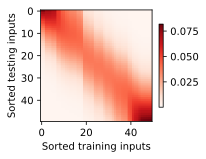

In [76]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## 2.4 带参数注意力汇聚

- 非参数的Nadaraya‐Watson核回归具有一致性（consistency）的优点：如果有足够的数据，此模型会收敛到最优结果。尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

- 例如，在查询$x$和键$x_ i$之间的距离乘以可学习参数$w$:

$$ \begin{aligned} f(x) & = \sum _ { i = 1 } ^ { n } \alpha ( x , x _ { i } ) y _ { i } \\ & = \sum _ { i = 1 } ^ { n } \frac { \exp \left( - \frac { 1 } { 2 } ( ( x - x _ { i } ) w ) ^ { 2 } \right) } { \sum _ { j = 1 } ^ { n } \exp \left( - \frac { 1 } { 2 } ( ( x - x _ { j } ) w ) ^ { 2 } \right) } y _ { i } \\ & = \sum _ { i = 1 } ^ { n } softmax \left( - \frac { 1 } { 2 } ( ( x - x _ { i } ) w ) ^ { 2 } \right) y _ { i } \end{aligned} $$

### 2.4.1 批量矩阵乘法

- batch1：n个a*b的矩阵：$\mathbf{ X } _ 1 , \ldots , \mathbf{ X } _ n$

- batch2：n个b*c的矩阵：$\mathbf{ Y } _ 1 , \ldots , \mathbf{ Y } _ n$

- 它们的批量矩阵乘法得到n个a*c矩阵$\mathbf{ X } _ 1 \mathbf{ Y } _ 1 , \ldots , \mathbf{ X } _ n \mathbf{ Y } _ n$

- (n, a, b) * (n, b, c) -> (n, a, c)

In [77]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

- 在注意力机制背景中，我们可以使用批量矩阵乘法来计算小批量数据中的加权平均值。

In [78]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
# print(weights)
# print(values)
# print(weights.unsqueeze(1).shape) # (2,1,10)
# print(values.unsqueeze(-1).shape) # (2,10,1)
# print(torch.mm(weights,values.t()))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))


tensor([[[ 4.5000]],

        [[14.5000]]])

### 2.4.2 定义模型

- Nadaraya‐Watson核回归的带参数版本：

In [79]:
class NWKernelRegression(nn.Module): #与无参的类似
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为（查询个数，键值对个数）
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为（查询个数，键值对个数）
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

### 2.4.3 训练

- 将训练数据集变换为键和值用于训练注意力模型。在带参数的注意力汇聚模型中，任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算，从而得到其对应的预测输出。

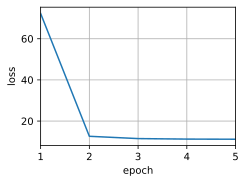

In [80]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1)) #x_train是一个行向量
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:(n_train，n_train-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) #除去对角线的元素
# values的形状:(n_train，n_train-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

# 使用平方损失函数和随机梯度下降训练
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

- 在尝试拟合带噪声的训练数据时，预测结果绘制的线不如之前非参数模型的平滑。

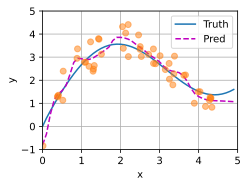

In [81]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

- 看一下输出结果的绘制图：与非参数的注意力汇聚模型相比，带参数的模型加入可学习的参数后，曲线在注意力权重较大的区域变得更不平滑。


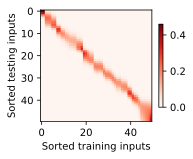

In [82]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),xlabel='Sorted training inputs',ylabel='Sorted testing inputs')